## **Notebook 4: Photometric Calibration of Realistic Image**
*Learning outcomes*
- We will learn about astronomical magnitude systems and the flux densities (or spectral energy distributions) of a star.
- We will learn about how to construct a bandpass of the instrument by combining multiple instrument components such as:
    - The telescope throughput
    - The camera quantum efficiency
    - The filter response
- We will then use realistic images of a g2v spectral type star observed by our instrument.
- We will clean the images using calibration images.
- We will then estimate the sky background level in digital units. 
- Knowing the spectral type of the star and the observed count rate, we will estimate the sensitivity of the instrument in different bands.
- Knowing the sensitivity, we will estimate the AB magnitude of the star as well as the night sky background per square arcsecond in the different bands.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.constants import c, h
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 20})

import convenience_functions as conv
from convenience_functions import plot_image

## **Photometry overview**
### **What is photometry?**
- Photometry is a technique used in astronomy to measure the flux or brightness of light radiated by astronomical sources.

### **Astronomical magnitude systems**
- The flux density (flux per unit wavelength or frequency interval) radiated by an astronomical object is typically expressed in two ways:
    1) Wavelength dependent flux density, $f_{\lambda}$ [erg/s/cm$^{2}$/nm]
    2) Frequency dependent flux density, $f_{\nu}$ [erg/s/cm$^{2}$/Hz]
- Astronomical magnitude systems are used to express the brightness of sources. Some examples are: (i) Vega magnitude system, (ii) Johnson magnitude system, and the (iii) AB magnitude system. 
- The AB magnitude system is an astronomical magnitude system based on flux density measurements that are calibrated in absolute units. In this notebook, we will use the AB magnitude system. 
- The AB magnitude system is defined such that when monochromatric flux density ($\bar{f_{\nu}}$) is measured in units of [erg/s/cm$^{2}$/Hz], then

\begin{equation}
m_{\rm AB} = -2.5 \log_{10}{\bar{f_{\nu}}} - 48.60
\end{equation}

- Given the bandpass of the instrument, $R(\lambda)$, the statistical mean of the flux density, $\bar{f_{\lambda}}$ is given by

\begin{equation}
\bar{f_{\lambda}} = \frac{\int_{\lambda} f_{\lambda} R(\lambda) \; \lambda d\lambda}{\int_{\lambda} R(\lambda)\;  \lambda d\lambda}
\end{equation}

- Using the *pivot wavelength* $\lambda_{p}$, one can convert from $\bar{f_{\nu}}$ and $\bar{f_{\lambda}}$

\begin{equation}
\lambda_{p}^{2} = \frac{\int_{\lambda} R(\lambda) \;\lambda d\lambda}{\int_{\lambda} R(\lambda) \;d\lambda/\lambda} 
\end{equation}

\begin{equation}
\bar{f_{\nu}} = \frac{\lambda_{p}^{2}}{c} \bar{f_{\lambda}}
\end{equation}

### **Spectral Energy Distribution of astronomical sources**
- The spectral energy distribution (SED) or the flux density of the astronomical source refers to the amount of flux observed from the source per unit wavelength or frequency interval. 
- The SED of sources can depend on various factors.
    1) Stars and galaxies have different SEDs. Stars appear as point sources on the image, whereas galaxies are extended objects.
    2) The SEDs of stars depends on the spectral type of the star, which in turn depends on the temperature and luminosity of the star. The figure below shows the normalized SEDs of stars of different spectral types. 
    
<img src="../plots/specprf.png">
     
    3) The SEDs of galaxies are different for ellipticals, spirals, starburst galaxies, and irregulars.

### **Instrument bandpass**
- The instrument bandpass informs how sensitive the instrument is at different wavelengths.
- The overall instrument bandpass consists of the multiplication of the transmission of different components in the instrument, including:
    1) *Telescope throughput*: this is the transmission of light through the telescope as a function of wavelength.
    2) *Camera quantum efficiency*: this is the sensitivity of the camera as a function of wavelength.
    3) *Filter transmission*: this is the transmission of light in a given filter as a function of wavelength.
- Other components are often also necessary, such as the transmission of specific coatings on mirrors. 

The instrument parameters for our instrument that we will use for thi notebook are:
- *Telescope diameter*: 0.5 meter
- *Telescope focal length*: 5500 mm
- *Camera dark current*: 0.1 [e/s/pixel]
- *Camera read noise*: 10 [e/pixel]
- *Camera full well capacity*: 50000
- *Camera pixel size*: 4 micron x 4 micron
- *Camera digitization resolution*: 16 bits
- *Camera bias level*: 200 ADU

### **Camera quantum efficiency**
- Below, we will plot the quantum effiency of the camera. To do so, we will make use of the `pandas` Python package.
- The instrument transmission data files for this notebook are located in `data/instrument/` from 300 nm to 1100 nm in 1 nm resolution.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


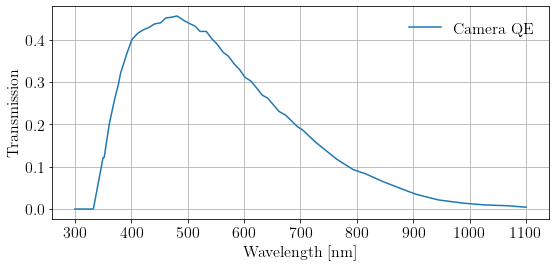

In [2]:
# Camera
camera = pd.read_csv("../data/instrument/camera/camera.csv")
camera_wave = camera['wavelength'].values
camera_trans = camera['transmission'].values

plt.figure(figsize=(8, 4))
plt.plot(camera_wave, camera_trans, label="Camera QE")
plt.grid()
plt.ylabel("Transmission")
plt.xlabel("Wavelength [nm]")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### **Exercise 1: Instrument bandpass**
- Construct an overall instrument bandpass by multiplying the transmission of the (i) telescope, and (ii) camera quantum efficiency, and (iii) filter transmission.
- There are 5 filters for our instrument, $u$, $b$, $v$, $r$, and $i$. 
- Therefore, construct five instrument bandpasses, one for each filter.
- Plot the 5 bandpasses on the same plot. 
    - Label the plot with legends.
    - Choose plot line colors that go with the bands 
        - $u$: violet, $b$: blue, $v$:green, $r$:red, $i$:maroon
- Which band has the highest peak transmission? 
- Which has the lowest peak transmission? What causes the transmission to drop so significantly in the band with the lowest peak transmission?

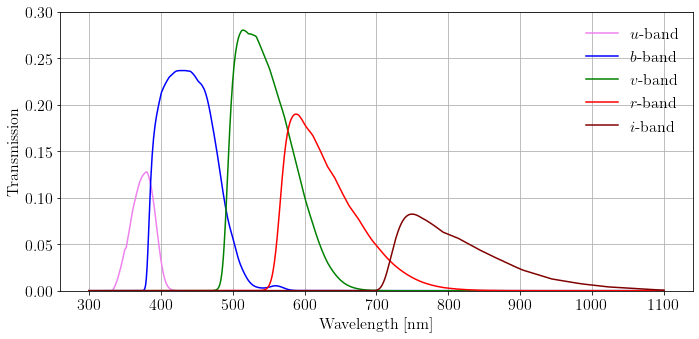

In [3]:
# Solution to Exercise 1
# Telescope
telescope = pd.read_csv("../data/instrument/telescope/telescope.csv")
telescope_wave = telescope['wavelength'].values
telescope_trans = telescope['transmission'].values

# Camera
camera = pd.read_csv("../data/instrument/camera/camera.csv")
camera_wave = camera['wavelength'].values
camera_trans = camera['transmission'].values

# Filters
uv = pd.read_csv("../data/instrument/filters/u.csv")
u_wave = uv['wavelength'].values
u_trans = uv['transmission'].values

b = pd.read_csv("../data/instrument/filters/b.csv")
b_wave = b['wavelength'].values
b_trans = b['transmission'].values

v = pd.read_csv("../data/instrument/filters/v.csv")
v_wave = v['wavelength'].values
v_trans = v['transmission'].values

r = pd.read_csv("../data/instrument/filters/r.csv")
r_wave = r['wavelength'].values
r_trans = r['transmission'].values

i = pd.read_csv("../data/instrument/filters/i.csv")
i_wave = i['wavelength'].values
i_trans = i['transmission'].values

# Overall bandpasses
u_tot = u_trans * camera_trans * telescope_trans
b_tot = b_trans * camera_trans * telescope_trans
v_tot = v_trans * camera_trans * telescope_trans
r_tot = r_trans * camera_trans * telescope_trans
i_tot = i_trans * camera_trans * telescope_trans

plt.figure(figsize=(10, 5))
plt.plot(u_wave, u_tot, label="$u$-band", color='violet')
plt.plot(b_wave, b_tot, label="$b$-band", color='blue')
plt.plot(v_wave, v_tot, label="$v$-band", color='green')
plt.plot(r_wave, r_tot, label="$r$-band", color='red')
plt.plot(i_wave, i_tot, label="$i$-band", color='maroon')
plt.grid()
plt.ylabel("Transmission")
plt.xlabel("Wavelength [nm]")
plt.legend(frameon=False)
plt.ylim(0, 0.3)
plt.tight_layout()
plt.show()

# The v-band has the highest peak transmission.
# The u-band has the lowest peak transmission. 
# The transmission drops rapidly in the u-band, because the CCD QE
# in the u-band drops significantly short-ward of 400 nm.

### **Convenience functions**
- Below, we have three functions that will be useful to us.
    1) `mean_flambda_from_flambda`:
        - The function takes as input a flux density array `flambda`, instrument bandpass `bandpass`, and an `wavelengths` array.
        - The function returns the statistical mean of the *wavelength* dependent flux density in that band. 
    2) `pivot_wavelength`:
        - The function takes as input a `bandpass` array and a `wavelengths` array.
        - The function returns the *pivot wavelength* in that band.
    3) `mean_fnu_from_flambda_pivot`:
        - The function takes as input a flux density array `flambda`, instrument bandpass `bandpass`, and an `wavelengths` array.
        - The function returns the statistical mean of the *frequency* dependent flux density in that band. 

In [4]:
def mean_flambda_from_flambda(flambda,
                              bandpass,
                              wavelengths):
    """
    Calculates the mean of the flux density in a band.
    inputs:
    1) flambda (numpy array): flux density array [erg/s/cm^2/nm]
    2) bandpass (numpy array): instrument bandpass in a given band
    3) wavelengths (numpy array): wavelengths over which the bandpass
        and flambda is defined
    outputs:
    1) flambda_mean (float): mean of the flux density [erg/s/cm^2/nm]
    """
    flambda *= u.erg/u.s/u.cm**2/u.nm
    
    wavelengths *= u.nm 
    
    del_lam = ((np.max(wavelengths) - np.min(wavelengths)) 
             / len(wavelengths))

    numerator = np.trapz(y=bandpass*flambda*wavelengths,
                         x=wavelengths,
                         dx=del_lam)
    denominator = np.trapz(y=wavelengths*bandpass,
                         x=wavelengths,
                         dx=del_lam)

    flambda_mean = (numerator/denominator).to(u.erg/u.s/u.cm**2/u.nm).value
    return flambda_mean

def pivot_wavelength(bandpass,
                     wavelengths): 
    """
    Calculates the pivot wavelength in a given band.
    inputs:
    1) bandpass (numpy array): instrument bandpass in a given band
    2) wavelengths (numpy array): wavelengths over which the bandpass
        and flambda is defined
    outputs:
    1) pivot_wave (float): pivot wavelength [nm]
    """
    wavelengths *= u.nm 
    integrand_num = bandpass * wavelengths
    integrand_den = bandpass / wavelengths

    del_lam =((np.max(wavelengths) - np.min(wavelengths)) 
               / len(wavelengths))

    numerator = (np.trapz(y=integrand_num, 
                          x=wavelengths,
                          dx=del_lam))

    denominator = (np.trapz(y=integrand_den, 
                            x=wavelengths,
                            dx=del_lam))

    pivot_wave = np.sqrt(numerator/denominator)

    return pivot_wave.to(u.nm).value

def mean_fnu_from_flam_pivot(flambda,
                             bandpass,
                             wavelengths):
    """
    Calculates the mean of the flux density [erg/s/cm^2/Hz]
    given the bandpass, wavelengths, and the wavelength dependent
    flux density [erg/s/cm^2/nm]
    inputs:
    1) flambda (numpy array): flux density array [erg/s/cm^2/nm]
    2) bandpass (numpy array): instrument bandpass in a given band
    3) wavelengths (numpy array): wavelengths over which the bandpass
        and flambda is defined
    outputs:
    1) mean_fnu (float): mean of the flux density [erg/s/cm^2/Hz]
    """
    
    mean_flambda = mean_flambda_from_flambda(flambda=flambda,
                                             bandpass=bandpass,
                                             wavelengths=wavelengths)
    mean_flambda *= (u.erg/u.s/u.cm**2/u.nm)
    
    piv_wave = pivot_wavelength(bandpass=bandpass,
                               wavelengths=wavelengths)
    piv_wave *= u.nm
    
    mean_fnu = (piv_wave**2 / c) * mean_flambda
    return mean_fnu.to(u.erg/u.s/u.cm**2/u.Hz).value

### **Exercise 2: flux density ($\bar{f_{\nu}}$) to AB magnitude converter function**
- Using the definition of AB magnitude in `Astronomical magnitude systems` above
- Write a function called `fnu_to_abmag`
- The function should take as input:
    1) `mean_fnu`: (float)
        - Statistical mean of the frequency dependent flux density, $\bar{f_{\nu}}$ in units of [erg/s/cm$^{2}$/Hz]
- The function should return:
    1) `ab_mag`: (float)
        - The AB magnitude correponsding to the mean of the frequency dependent flux density.

In [5]:
# Solution to Exercise 2
def fnu_to_abmag(mean_fnu):
    """
    Convert flux density [erg/s/cm^2/Hz] to ABmag
    input:
    1) mean_fnu (float): mean of the flux density [erg/s/cm^2/Hz]
    return:
    1) ab_mag (float): AB magnitude corresponding to mean_fnu
    """
    ab_mag = -2.5*np.log10(mean_fnu) - 48.60
    return ab_mag

### **Exercise 3: Spectral Energy Distribution of the star**
- Later in this notebook, we will perform photometric calibration of realistic images of a g2v type star (in 5 different bands).
- Plot the SED (or flux density) of the star. 
- The flux density [erg/s/cm$^{2}$/nm] as a function of wavelength [nm] data for the stars is given in `../data/star_spectra/g2v_spectrum.csv`.
- In which band does the SED peak in?

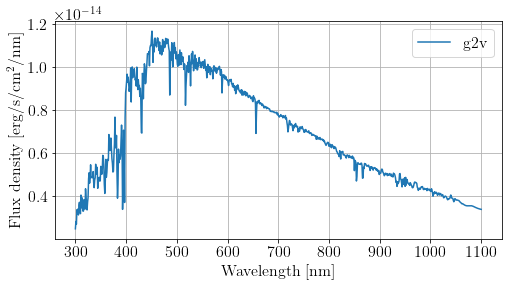

In [6]:
# Solution to Excerise 3
g2v = pd.read_csv('../data/star_spectra/g2v_spectrum.csv')

g2v_wave = g2v.wavelengths.values
g2v_flambda = g2v.flambda.values

plt.figure(figsize=(8,4))
plt.plot(g2v_wave, 
         g2v_flambda, label='g2v')
plt.grid()
plt.xticks(np.arange(300,1200,100))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux density [erg/s/cm$^{2}$/nm]')
plt.legend()
plt.show()

# The SED of the star peaks in the Blue.

## **Photometric calibration of single $u$-band image**
- Below, we will perform photometric calibration on a realistic image of a g2v-type star observed in the $u$-band of our instrument. 
- First, we will open the raw image and plot it using the `plot_image` convenience function
- The simulated image is in `../data/star_image/g2v/u.fits`

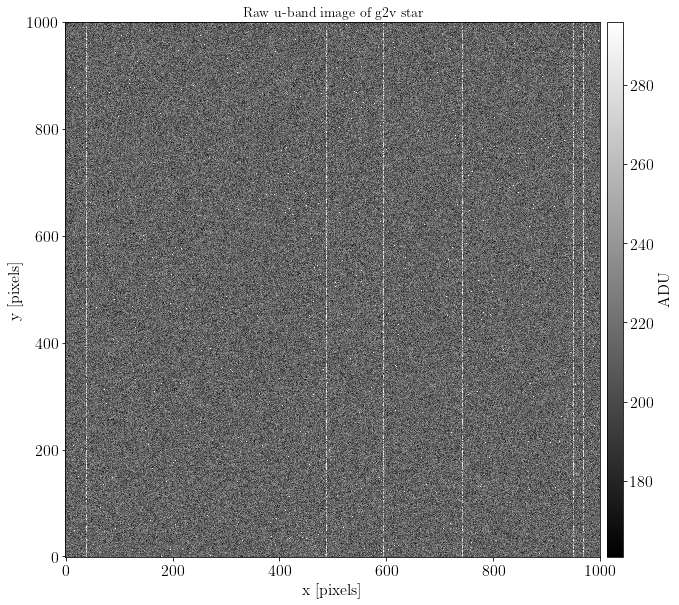

In [7]:
# Step 1: Open the raw image and plot it using 
band = 'u'
source = 'g2v'
bandpass = u_tot
wavelengths = u_wave
exposure_time = 100 # seconds

raw = fits.open("../data/star_image/"+source+'/'+band+'.fits')[0].data
plot_image(raw, title='Raw '+band+'-band image of ' +source+ ' star')

- The raw images contains dark current, hot pixels, a bias level (and bad bias columns), sky noise, and read noise. We will need to clean the image before we can perform photometeric calibration on the star to find its observed brightness.

### **Exercise 4: Dark current subtraction**
- A master dark frame (with the same 100 second exposure time) as the raw image is available under `../data/calibration_images/dark.fits`.
- Open and plot the dark frame. 
- Note that dark frame also contains the bias features, so we do not need to subtract the bias frame from the raw image separately.
- Subtract the dark frame from the raw image. Plot the dark subtracted raw image. 
- What is the difference between the raw image and the raw image after it has been dark subtracted?

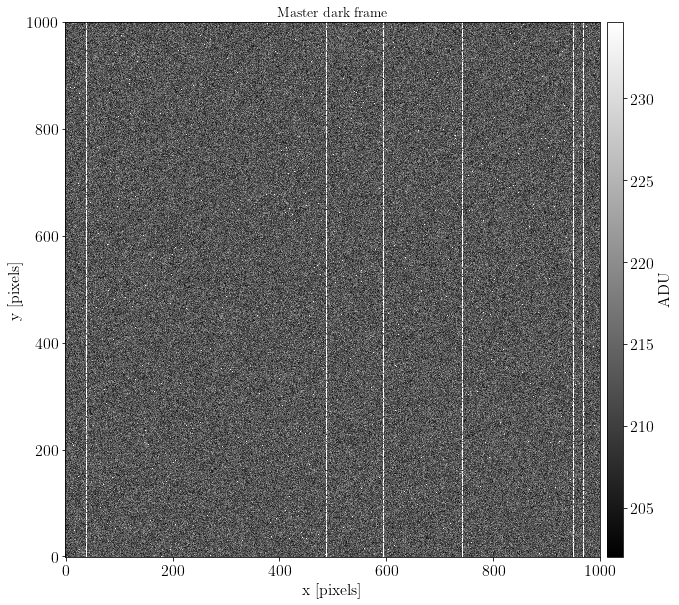

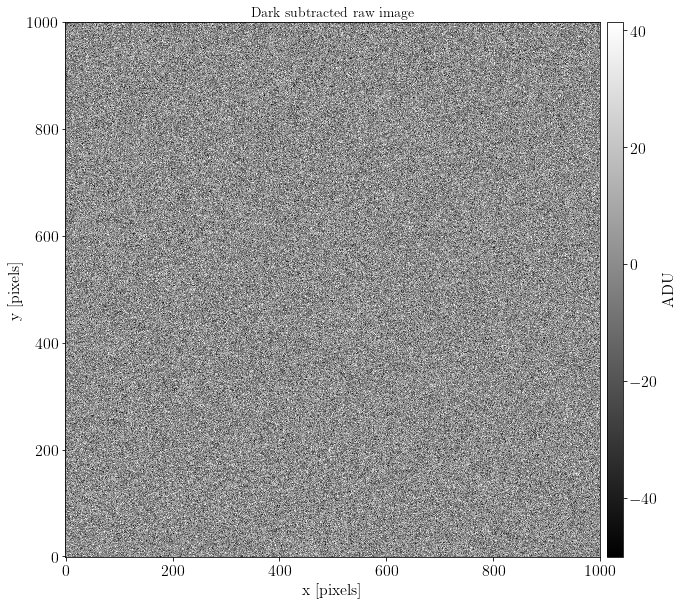

In [8]:
# Solution to Exercise 4
dark = fits.open("../data/calibration_images/dark.fits")[0].data
plot_image(dark, title='Master dark frame')

raw_dark = raw - dark
plot_image(raw_dark, title='Dark subtracted raw image')

# After the raw image is dark subtracted, the dark current and hot pixels are removed
# from the image and the bias features are also removed from the image.

### **Exercise 5: Flat field correction**
- A master flat field (which informs us about the pixel-to-pixel variations across the CCD) is also available under `../data/calibration_images/flat.fits`.
- The master flat field image has already been normalized and dark subtracted.
- Open and plot the flat field image.
- Divide the dark subtracted image by the flat field to get to our dark and flat corrected image.
- Plot the dark and flat corrected image.

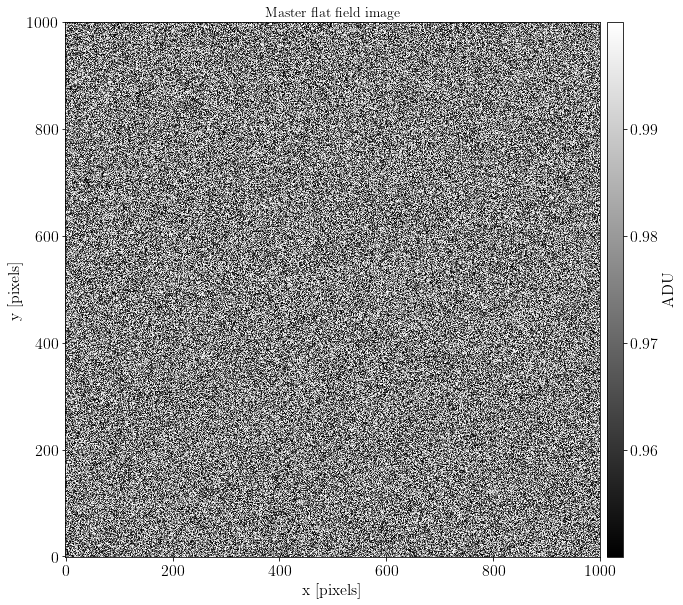

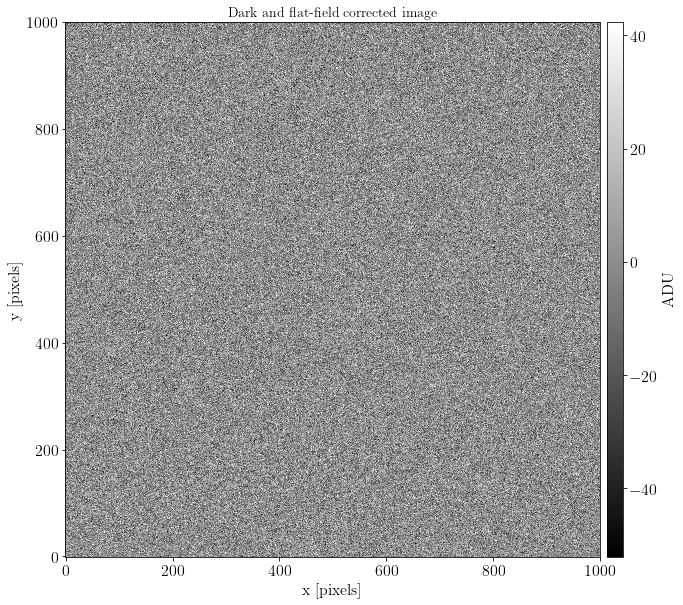

In [9]:
# Solution to Exercise 5
flat = fits.open("../data/calibration_images/flat.fits")[0].data
conv.plot_image(flat, title='Master flat field image')

dark_flat = raw_dark / flat
conv.plot_image(dark_flat, title='Dark and flat-field corrected image')

### **Exercise 6: Sky background estimation and subtraction**
- After the raw image has been dark subtracted and flat field corrected, we need to remove the sky background noise component from the image.
- To estimate the sky background level in the image, we will perform 3-sigma clipping. 
    - This means that we will remove all values in our images that are $\pm 3\sigma$ away from the mean.
    - To do so, we will use the convenient function called `sigma_clip` from the `astropy.stats` module.
- Import the `sigma_clip` function from the `astropy.stats` module.
- Set the `data` parameter to the flat field corrected image from the previous step.
- Set the `sigma` parameter to `3`.
- Set the `maxiters` paramter to `None`.
- Plot the histogram of the sigma clipped data. 
- We will take the mean of the sigma clipped data as the estimate for the sky background level (in ADU units).
- Print the mean of the sigma clipped data.
- Subtract the mean background level form the dark and flat-field corrected image to get to our final *cleaned* image.
- Plot the cleaned image

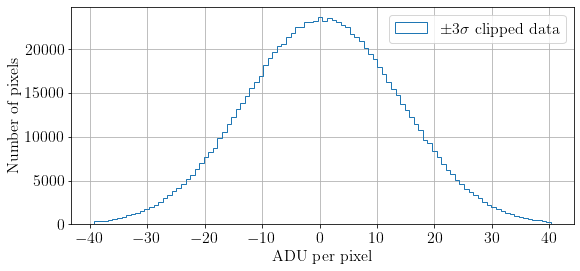

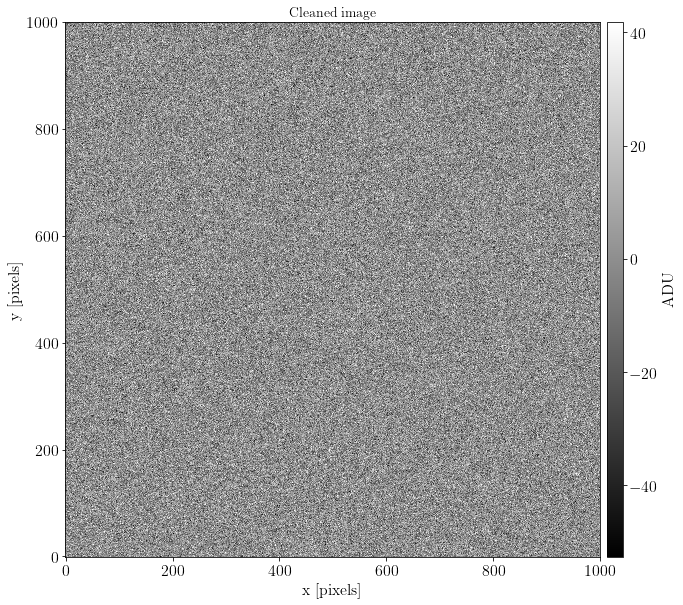

In [10]:
# Solution to Exercise 6
from astropy.stats import sigma_clip

sigma_clipped = sigma_clip(data=dark_flat,
                           sigma=3,
                           maxiters=None)

plt.figure(figsize=(9,4))
plt.hist(sigma_clipped.ravel(), 
         histtype='step',
         bins=100,
        label='$\pm3\sigma$ clipped data')
plt.xlabel("ADU per pixel")
plt.legend()
plt.grid()
plt.ylabel("Number of pixels")
plt.show()

bkg_mean = np.mean(sigma_clipped)
clean = dark_flat - bkg_mean

plot_image(clean, title="Cleaned image")

### **Exercise 7: Instrument sensitivity calculation**
- If the instrument bandpass and the SED of the source is known, we can calculate the sensitivity of each given band.
- From the discussion in `Astronomical magnitude systems` above, we saw that we calculate the mean of the frequency dependent flux density in a given band, provided we know the instrument bandpass in that band and the SED of the source.
- From the *cleaned* image, we can also calculate the ADU count rate observed for the source.
- Then, we can define a sensitivity parameter called $\alpha$ defined as

\begin{equation}
\alpha = \frac{\text{ADU/s} \;\text{from the source}}{\bar{f_{\nu}}\; \text{from the source}} = \frac{\text{[ADU/s]}}{\text{[erg/s/cm$^{2}$/Hz]}}
\end{equation}

- Therefore, a higer $\alpha$ would indicate a higher instrument sensivity in that band, in that more counts are detected for a higher alpha for the same mean flux density.
- Therefore, to calculate the sensitivity, we need two quantities.
    1) Count rate of source
        - To estimate the count rate of the source, we will use the `Cutout2D` module of `astropy`. 
        - Import the module using `from astropy.nddata import Cutout2D`
        - Set `position = (505, 505)` since the source is simulated to be at the center of the image
        - Set `size = (5,5)`
        - Define `cutout = Cutout2D(clean, position, size)`, where clean is the cleaned image
        - Plot the cutout data (which can be accessed by `cutout.data`)
        - Sum all of the counts in the cutout. Hint: you can use `numpy.sum(cutout.data)`
        - Estimate the count *rate* from the source by diving the counts by the exposure time, which is 100 seconds.
    
    2) Mean flux density
        - To estimate the mean flux density of the source, use the `mean_fnu_from_flam_pivot` function defined above.
        - For the `bandpass`, provide the transmission array of the bandpass (`u_tot` in this case).
        - For the `wavelengths`, provide the wavelengths array of the bandpass (`u_wave` in this case).
        - For the `flambda`, provide the wavelength dependent flux density array of the source (`g2v_flambda` in this case).
- Take the ratio of the count rate and the mean flux density to estimate $\alpha$.
- Print and record the value of $\alpha$ for this source and band. 

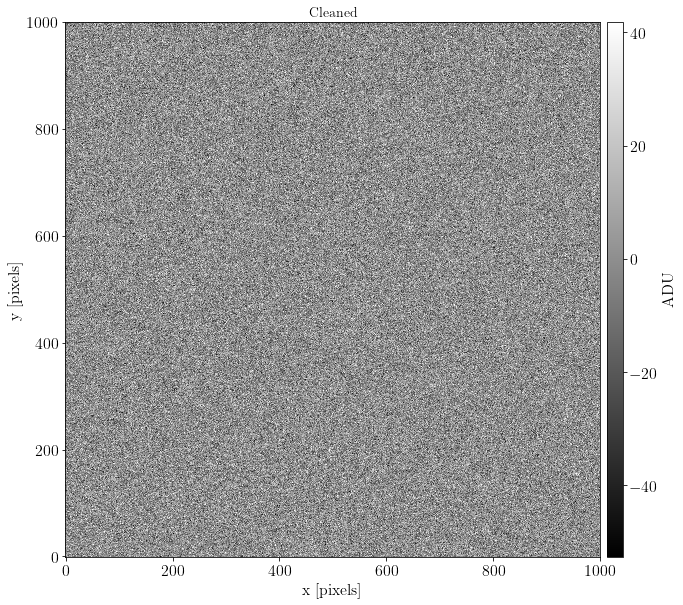

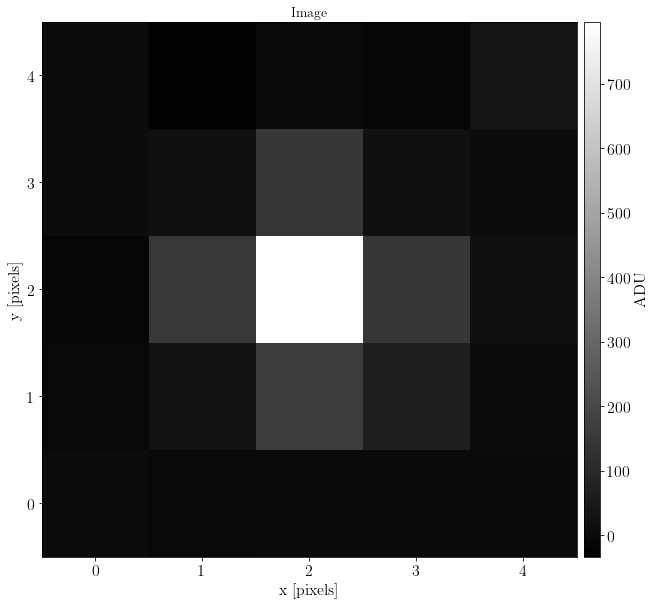

Alpha is 5.93E+27 [ADU/s] / [erg/s/cm^2/Hz]


In [11]:
from astropy.nddata import Cutout2D
position = (505, 505)
size = (5,5)
cutout = Cutout2D(clean, position, size)

plot_image(clean, title='Cleaned')
plot_image(cutout.data, default_ticks=True,
               interval_type='percentile')

counts = np.sum(cutout.data)

flambda = g2v_flambda

mean_fnu = mean_fnu_from_flam_pivot(bandpass=bandpass,
                                   flambda=flambda,
                                   wavelengths=wavelengths)

alpha = (counts/exposure_time) / mean_fnu

print("Alpha is {:.2E} [ADU/s] / [erg/s/cm^2/Hz]".format(alpha))

### **Exercise 8: AB magnitude of the source**
- Knowning $\bar{f_{\nu}}$, we can calculate the AB magnitude of the source.
- Use the `fnu_to_abmag` function you wrote above to estimate the AB magnitude of the source.
- Print and record the result.

In [12]:
# Solution to Exercise 8
ab_mag_source = fnu_to_abmag(mean_fnu=mean_fnu)
print("AB magnitude of the source is: {:.2f}".format(ab_mag_source))

AB magnitude of the source is: 17.80


### **Exercise 9: AB magnitude of the sky background**
- Knowing the background count rate and $\alpha$, we can also calculate the AB magnitude per pixel and AB magnitude per square arcseconds of the sky background for the different bands.
- Take the mean background counts you calculated above and divide by the exposure time.
- Calculate the mean background frequency dependent flux density per pixel, $\bar{f_{\nu, \,bkg}}$ per pixel.
- Given $\bar{f_{\nu, \,bkg}}$ per pixel, calculate the AB magnitude of the sky background per pixel.
- To calculate the AB magnitude of the sky background per square arcseconds, we will need to calculate the plate scale of the instrument. 
- The plate scale of the instrument can be calculated by:

\begin{equation}
P = \frac{20626 \times \mu}{1000 \times f}
\end{equation}

where P is the plate scale [arcsecond/pixel], $\mu$ is the camera pixel size [micron], and $f$ is the focal length of the telescope [mm].
- Then, the mean background frequency dependent flux density per square arcsecond is simply $\bar{f_{\nu, \,bkg}}$ per pixel divided by $P^{2}$.
- Calculate, print, and record the AB magnitude of the sky background per square arcsecond.

In [13]:
# Solution to Exercise 9
bkg_fnu_pix = (bkg_mean/exposure_time) / alpha
bkg_abmag_pix = conv.fnu_to_abmag(bkg_fnu_pix)

pixel_size = 4.5 # micron
focal_length = 5500 # mm
plate_scale = plate_scale = ((206265 * pixel_size) / (1000 * focal_length))

bkg_fnu_arcsec = bkg_fnu_pix / plate_scale**2
bkg_abmag_arcsec = conv.fnu_to_abmag(bkg_fnu_arcsec)

print("Sky background is: {:.2f} AB mag per pixel".format(bkg_abmag_pix))
print("Sky background is: {:.2f} AB mag per square arcseconds".format(bkg_abmag_arcsec))

Sky background is: 26.57 AB mag per pixel
Sky background is: 22.71 AB mag per square arcseconds


### **Exercise 10: Photometric Calibration of all instrument bands**
- Repeat the above exercises for all bands. 
- You might find it easier to do so in a loop.
- For each band, print and record:
    - The sensitivity parameter $\alpha$
    - The AB magnitude of the star
    - The AB magnitude per square arcsecond of the sky background
- Compare these three parameters for the different bands.
- Which band is the most sensitive?
- Which band has the darkest sky background level? Why band has the brightest? 
- Why could the sky be brighter in one band compared to the other?
- The star appears brightest in which band? Dimmest?

In [14]:
# Solution to Exercise 10
bands = ['u', 'b', 'v', 'r', 'i']
trans_dict = {'u':u_tot,
              'b':b_tot,
              'v':v_tot,
              'r':r_tot,
              'i':i_tot}
wavelengths = u_wave

source = 'g2v'
exposure_time = 100
pixel_size = 4.5 # micron
focal_length = 5500 # mm
plate_scale = plate_scale = ((206265 * pixel_size) / (1000 * focal_length))

dark = fits.open("../data/calibration_images/dark.fits")[0].data
flat = fits.open("../data/calibration_images/flat.fits")[0].data

for band in bands:
    bandpass = trans_dict[band]

    raw = fits.open("../data/star_image/"+source+'/'+band+'.fits')[0].data

    raw_dark = raw - dark

    dark_flat = raw_dark / flat

    sigma_clipped = sigma_clip(data=dark_flat,
                               sigma=3,
                               maxiters=None)

    bkg_mean = np.mean(sigma_clipped)

    clean = dark_flat - bkg_mean

    position = (505, 505)
    size = (5,5)
    cutout = Cutout2D(clean, position, size)

    counts = np.sum(cutout.data)

    if source == 'g2v':
        flambda = g2v_flambda

    mean_fnu = mean_fnu_from_flam_pivot(bandpass=bandpass,
                                       flambda=flambda,
                                       wavelengths=wavelengths)

    ab_mag_source = fnu_to_abmag(mean_fnu=mean_fnu)
    alpha = (counts/exposure_time) / mean_fnu

    bkg_fnu_pix = (bkg_mean/exposure_time) / alpha
    bkg_abmag_pix = conv.fnu_to_abmag(bkg_fnu_pix)

    bkg_fnu_arcsec = bkg_fnu_pix / plate_scale**2
    bkg_abmag_arcsec = conv.fnu_to_abmag(bkg_fnu_arcsec)

    print("\nFor the {} band:".format(band))
    print("Alpha is {:.2E} [ADU/s] / [erg/s/cm^2/Hz]".format(alpha))
    print("AB magnitude of the source is: {:.2f}".format(ab_mag_source))
    print("Sky background is: {:.2f} AB mag per square arcseconds".format(bkg_abmag_arcsec))


For the u band:
Alpha is 5.93E+27 [ADU/s] / [erg/s/cm^2/Hz]
AB magnitude of the source is: 17.80
Sky background is: 22.71 AB mag per square arcseconds

For the b band:
Alpha is 2.15E+28 [ADU/s] / [erg/s/cm^2/Hz]
AB magnitude of the source is: 16.91
Sky background is: 22.94 AB mag per square arcseconds

For the v band:
Alpha is 1.95E+28 [ADU/s] / [erg/s/cm^2/Hz]
AB magnitude of the source is: 16.41
Sky background is: 21.94 AB mag per square arcseconds

For the r band:
Alpha is 1.24E+28 [ADU/s] / [erg/s/cm^2/Hz]
AB magnitude of the source is: 16.24
Sky background is: 21.24 AB mag per square arcseconds

For the i band:
Alpha is 5.55E+27 [ADU/s] / [erg/s/cm^2/Hz]
AB magnitude of the source is: 16.07
Sky background is: 20.02 AB mag per square arcseconds


- The $b$ band is the most sensitive.
- The $i$ band is the least sensitive.
- The star appears brightest in the $i$ band and dimmest in the $u$ band. Even though $i$ is less sensitive, it has a broad band and captures the spectral energy distribution of the g2v star well. 
- The sky background is dimmest in the $b$ band and brightest in the $i$ band. The night sky tends to get brighter red-ward of blue due to airglow emission lines.
- Typical values at La Palma (see [Benn and Ellison 1998](https://ui.adsabs.harvard.edu/abs/1998NewAR..42..503B/abstract)) are:
    - $u$: 22.0, $b$: 22.7, $v$: 21.9, $r$:21.0, $i$: 20.0